# Assignment 2

Use this notebook to write your code for assignment 2

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
# Device configuration
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Baseline Model

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [23]:
def one_hot(p, dim):
    t = np.array(p)
    o = np.zeros(t.shape+(dim,), dtype=int)
    o[np.arange(t.shape[0]), t] = 1
    return o

In [24]:
### read data
# data = open('data/shakespeare.txt').read()
# data = data.lower()

In [25]:
# modify dataset to remove sonnet numbers and extrenuous newlines
# read data for modification

with open('data/shakespeare.txt') as data_file:
    lines = data_file.readlines()

i = 0
data_mod = ""
for line in lines:
    line = line.lower()
    line = line.strip(" ")
    line_digit = line.strip()
    if len(line) == 0 or line == ' ':
#         print('blank')
        continue
    elif line_digit.isdigit():
#         print(line)
        continue
#     elif line == '\n':
# #         print('new line')
#         continue
    
#     print('--->', line)
    data_mod += line
    
#     i += 1
#     if i > 20:
#         break

data = data_mod
# print(data)

In [26]:
unique_char = sorted(list(set(data)))  # unique characters present
int_to_char = {n:char for n, char in enumerate(unique_char)}  # mapping for char to integer
char_to_int = {char:n for n, char in enumerate(unique_char)}  # mapping for integer to character
X = []
Y = []
data_length = len(data)
sequence_length = 40   # fixed length sequnce of 40 characters
skip_length = 4   # start every 5th character for a new sequence
sonnet_line = 0
for i in range(0, data_length-sequence_length, skip_length):
    seq = data[i:i+sequence_length]  # generate sequence
    label = data[i+sequence_length]  # next character as the label for prediction
    # print(seq, '--->', label)
    X.append([char_to_int[char] for char in seq])
    Y.append(char_to_int[label])
    
    # sonnet_line += 1
    # if sonnet_line > 320:
    #   break
    
### reshaping the data
# print(len(X))
Xd = np.reshape(X, (len(X), sequence_length, 1))  
Xd = Xd/len(unique_char)  # divide each value by the number of unique character to keep the value in [0,1]
# Yd = one_hot(Y, len(unique_char))
# Yd = np.reshape(Y, (-1, 1))
Yd = np.array(Y)
print(Xd.shape)
print(Yd.shape)

(23485, 40, 1)
(23485,)


In [27]:
# parameters
seq_length = 40
input_feature = 1  # feature for each timestep in the sequence
batch_size = 32 
char_set_size = len(unique_char)  # unique character set -> number of possible classes for output
hidden_size = 150  # lstm units
lstm_layers = 1  
learning_rate = 0.01
n_epochs = 100

# Build the Model

Implement a character-based LSTM model 

In [28]:
###
class Poem(nn.Module):
    def __init__(self, sequence_length, input_size, hidden_size, num_layers, output_size, device):
        super(Poem, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.device=device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0)
        
        self.fc = nn.Linear(hidden_size*sequence_length, output_size)

    def init_hidden(self, batch_size):
        self.h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        self.c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        
    def forward(self, x, T=1):  # T is temperature
        x, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
        x = x.contiguous().view(-1, self.hidden_size*self.sequence_length)
        x = self.fc(x)
#         x = x.view(-1, self.output_size)
        out = F.log_softmax(x/T, dim=1)  # use temperature for softmax
        return out
        

In [29]:
poem_generator = Poem(seq_length, input_feature, hidden_size, lstm_layers, char_set_size, device).to(device)

# Training

The main training routine

In [30]:
###
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poem_generator.parameters(), lr=learning_rate)

## function to train each batch
def batch_train(Xb, Yb):
    poem_generator.train()
    optimizer.zero_grad()
    poem_generator.init_hidden(Xb.shape[0])
    
    output = poem_generator(Xb)
    
    loss = criterion(output, Yb)
    ls = loss.item()
    loss.backward()
    optimizer.step()
    
    return ls


# function to train the the whole data
def train_model(dataX, dataY, batch_size, epochs=10):
    min_loss = np.inf
    train_losses = []
    for epoch in range(0, epochs):
        train_loss = 0.0
        # create each batch and train
        for i in range(0, dataX.shape[0]-batch_size, batch_size):
            Xb = dataX[i:i+batch_size]
            Yb = dataY[i:i+batch_size]
            ls = batch_train(torch.tensor(Xb, dtype=torch.float), torch.tensor(Yb, dtype=torch.long))
            train_loss += (ls/batch_size)
        
        train_losses.append(train_loss)
        
        # save each model if performs better (decrease loss)
        if min_loss > train_loss:
            min_loss = train_loss
            torch.save(poem_generator.state_dict(), 'model_poem_generator.pt')
        print('epoch: ', epoch, 'training loss: ', train_loss)
    
    return train_losses

In [31]:
## train the model
n_epochs = 100
train_losses = train_model(Xd, Yd, batch_size, epochs=n_epochs)

epoch:  0 training loss:  66.16970977932215
epoch:  1 training loss:  62.88809998333454
epoch:  2 training loss:  60.491877403110266
epoch:  3 training loss:  58.678540863096714
epoch:  4 training loss:  57.14617080613971
epoch:  5 training loss:  55.86824053525925
epoch:  6 training loss:  54.7526436522603
epoch:  7 training loss:  53.96850232034922
epoch:  8 training loss:  53.49685489013791
epoch:  9 training loss:  52.68392889946699
epoch:  10 training loss:  52.31083453819156
epoch:  11 training loss:  51.56176011823118
epoch:  12 training loss:  51.236208245158195
epoch:  13 training loss:  50.40342712402344
epoch:  14 training loss:  49.99356620013714
epoch:  15 training loss:  49.23635776154697
epoch:  16 training loss:  48.31373192742467
epoch:  17 training loss:  47.852174861356616
epoch:  18 training loss:  47.393296082504094
epoch:  19 training loss:  46.033346362411976
epoch:  20 training loss:  46.9768788870424
epoch:  21 training loss:  49.157874894328415
epoch:  22 trai

Poem Generation

In [32]:
### function to generate poems from a seed

def generate_poem(poem_model, initial_seed, num_char_gen, t=1):  # num_char_gen: how many characters is to be generated
    seed = copy.deepcopy(initial_seed)  # random seed
    generated_poem = [int_to_char[value] for value in seed]
    
    for i in range(num_char_gen):
        Xt = np.reshape(seed, (1, len(seed), 1))
        Xt = Xt/char_set_size

        Xt = torch.tensor(Xt, dtype=torch.float)
        poem_model.init_hidden(Xt.shape[0])
        y = torch.argmax(poem_model(Xt, T=t))
        index = y.numpy().item(0)

        generated_poem.append(int_to_char[index])

        ## consider next seed by taking the last 40-characters including the predicted new character
        seed.append(index)
        seed = seed[1:len(seed)]
        
    poem_text = ""
    for char in generated_poem:
        poem_text += char

#     print(poem_text)
    return poem_text

## Generate Poem

In [33]:
## load the saved model
poem_model = Poem(seq_length, input_feature, hidden_size, lstm_layers, char_set_size, device).to(device)
poem_model.load_state_dict(torch.load('model_poem_generator.pt'))

In [49]:
# generate a poem with 400 predicted characters with temperature 1, with random seed X[12] from data

print(generate_poem(poem_model, X[12], 400, t=1))  # random seed X[12]

thereby beauty's rose might never die,
bod ths hermpse thfls tiun ooe hatme iy t:y iedt whetheh po ho sia teesu thov toa tosesge gl tiy sems heue,ltoneyhnns?iye,
inv fod moi maldmlef fo aidec psohd tha tith, oytuy lftiy fouia io sei whmn. on thyec thy blvia toee ia,tti toyy iattt: wiin gerdry loeke tow sieue,
thot oh mat sia helme lo to theh thete,
thi colrr io to thef tooue,s tfeci rp to the golld than.
ther gnus oo ml shlt thetu,s oy 


# Plotting the Training Losses

Plotting the historical loss during training:

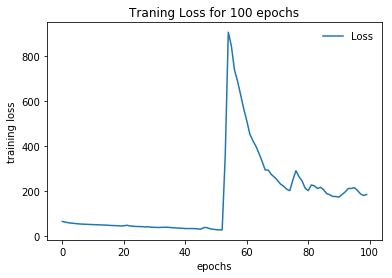

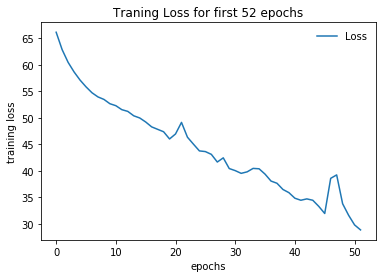

In [40]:
###
#************************************#
# print('Epoch\tTraining Loss')
# for i in range(n_epochs):
#    print(i+1, '\t{:.8f}'.format(train_losses[i]))

plt.plot(train_losses, label='Loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Traning Loss for 100 epochs')
plt.show()
#************************************#


## training loss for first 52 epochs
plt.plot(train_losses[:52], label='Loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Traning Loss for first 52 epochs')
plt.show()

# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.

In [36]:
### generate poems for different temperatures
ts = [1.5, 0.75, 0.25]
seed_str = "shall i compare thee to a summer's day?\n"
seed = [char_to_int[char] for char in seed_str]

for temp in ts:
    poem_model = Poem(seq_length, input_feature, hidden_size, lstm_layers, char_set_size, device).to(device)
    poem_model.load_state_dict(torch.load('model_poem_generator.pt'))
    
    poem = generate_poem(poem_model, seed, 400, t=temp)

    print('Temperature: ', temp)
    print('------------------------------------------------------------------')
    print(poem)
    print('------------------------------------------------------------------')

Temperature:  1.5
------------------------------------------------------------------
shall i compare thee to a summer's day?
osrn eeiaso fnd deenh: sw heaeth co thg,srm. hendite fr i vr,py lfee thdt, thanr iiatf ene lin shrt whete tuet thih arla in c iovldd enteht.
why hnlr thlfrest ho f soiic fnananr
tioc, toatogette oo si soass iea tywen shite to toecc fote: saklni toa eoyo'to, cey hn i coewiln lfaet
ohu ayu aai taeevn vhoe teot oy thas shn ieier shy sheferten thon mo coe iease loase
toeltgt,
then iy toi, ialdy fodd v
------------------------------------------------------------------
Temperature:  0.75
------------------------------------------------------------------
shall i compare thee to a summer's day?
osrn eeiaso fnd deenh: sw heaeth co thg,srm. hendite fr i vr,py lfee thdt, thanr iiatf ene lin shrt whete tuet thih arla in c iovldd enteht.
why hnlr thlfrest ho f soiic fnananr
tioc, toatogette oo si soass iea tywen shite to toecc fote: saklni toa eoyo'to, cey hn i coewiln lfaet


# Improved Model

In [355]:
import nltk
# nltk.download()
from nltk.tokenize import RegexpTokenizer

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [356]:
data = open('data/shakespeare.txt').read()
# word_data = nltk.word_tokenize(data)
tokenizer = RegexpTokenizer('\w+|\S+|\\n+')  # tokenize the data
word_data_raw = tokenizer.tokenize(data)
word_data = [word.lower() for word in word_data_raw]  # convert to lowercase

In [357]:
unique_words = sorted(list(set(word_data)))  # unique number of words
int_to_word = {n:word for n, word in enumerate(unique_words)}  # map wod to integer
word_to_int = {word:n for n, word in enumerate(unique_words)}  # map integer to word
X = []
Y = []
data_length = len(word_data)
sequence_length = 10   # sequence of 10-words
skip_length = 4  # start every 5th word for a new sequence
for i in range(0, data_length-sequence_length, skip_length):
    seq = word_data[i:i+sequence_length]
    label = word_data[i+sequence_length]
#     print(seq, ' -->', label)
#     break
    X.append([word_to_int[word] for word in seq])
    Y.append(word_to_int[label])
    
# # print(len(X))
Xd = np.reshape(X, (len(X), sequence_length, 1))
Xd = Xd/len(unique_words)
# # Yd = one_hot(Y, len(unique_char))
# # Yd = np.reshape(Y, (-1, 1))
Yd = np.array(Y)
print(Xd.shape)
print(Yd.shape)

(5760, 10, 1)
(5760,)


In [360]:
# parameters
seq_length = 10  # each sequence is 10 words
input_feature = 1  # each timestep of the sequence has one feature (only the word)
batch_size = 32
word_set_size = len(unique_words)
hidden_size = 150
lstm_layers = 2
learning_rate = 0.001
n_epochs = 200

# Build the Model

Implement a character-based LSTM model 

In [353]:
###
class Poem(nn.Module):
    def __init__(self, sequence_length, input_size, hidden_size, num_layers, output_size, device):
        super(Poem, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.device=device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        
        self.fc = nn.Linear(hidden_size*sequence_length, output_size)

    def init_hidden(self, batch_size):
        self.h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        self.c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        
    def forward(self, x, T=1):
        x, (self.h0, self.c0) = self.lstm(x, (self.h0, self.c0))
        x = x.contiguous().view(-1, self.hidden_size*self.sequence_length)
        x = self.fc(x)
#         x = x.view(-1, self.output_size)
        out = F.log_softmax(x/T, dim=1)
        return out
        

In [361]:
poem_word_gen = Poem(seq_length, input_feature, hidden_size, lstm_layers, word_set_size, device).to(device)

# Training

In [362]:
###
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poem_word_gen.parameters(), lr=learning_rate)

def batch_train(Xb, Yb):
    poem_word_gen.train()
    optimizer.zero_grad()
    poem_word_gen.init_hidden(Xb.shape[0])
    
    output = poem_word_gen(Xb)
    
    loss = criterion(output, Yb)
    ls = loss.item()
    loss.backward()
    optimizer.step()
    
    return ls


def train_model(dataX, dataY, batch_size, epochs=10):
    min_loss = np.inf
    train_losses = []
    for epoch in range(0, epochs):
        train_loss = 0.0
        for i in range(0, dataX.shape[0]-batch_size, batch_size):
            Xb = dataX[i:i+batch_size]
            Yb = dataY[i:i+batch_size]
            ls = batch_train(torch.tensor(Xb, dtype=torch.float), torch.tensor(Yb, dtype=torch.long))
            train_loss += (ls/batch_size)
        
        train_losses.append(train_loss)
        
        if min_loss > train_loss:
            torch.save(poem_word_gen.state_dict(), 'model_poem_word_gen.pt')
        print('epoch: ', epoch, 'training loss: ', train_loss)
    
    return train_losses

In [367]:
## train for 200 epochs
n_epochs = 200
train_losses = train_model(Xd, Yd, batch_size, epochs=n_epochs)

epoch:  0 training loss:  25.219044387340546
epoch:  1 training loss:  24.219913199543953
epoch:  2 training loss:  22.74398197978735
epoch:  3 training loss:  21.535372279584408
epoch:  4 training loss:  20.211220860481262
epoch:  5 training loss:  19.232039593160152
epoch:  6 training loss:  18.52796360850334
epoch:  7 training loss:  17.622257478535175
epoch:  8 training loss:  16.86232427507639
epoch:  9 training loss:  15.745437614619732
epoch:  10 training loss:  14.63109540939331
epoch:  11 training loss:  13.646901305764914
epoch:  12 training loss:  13.279575016349554
epoch:  13 training loss:  12.976843737065792
epoch:  14 training loss:  12.99454179033637
epoch:  15 training loss:  12.713953647762537
epoch:  16 training loss:  12.075177896767855
epoch:  17 training loss:  11.764136828482151
epoch:  18 training loss:  11.280697837471962
epoch:  19 training loss:  10.921795386821032
epoch:  20 training loss:  10.336600851267576
epoch:  21 training loss:  9.497475251555443
epoc

epoch:  176 training loss:  0.08932932719108067
epoch:  177 training loss:  0.12827184591878904
epoch:  178 training loss:  0.1257866652795201
epoch:  179 training loss:  0.09652337915758835
epoch:  180 training loss:  0.14509153613289527
epoch:  181 training loss:  0.18345255110034486
epoch:  182 training loss:  0.16580485539634537
epoch:  183 training loss:  0.17498224356677383
epoch:  184 training loss:  0.09050322441544267
epoch:  185 training loss:  0.14011152683087857
epoch:  186 training loss:  0.1187199447540479
epoch:  187 training loss:  0.13159900381288026
epoch:  188 training loss:  0.1285035543533013
epoch:  189 training loss:  0.09750888888902409
epoch:  190 training loss:  0.17709994128153994
epoch:  191 training loss:  0.2304085740188384
epoch:  192 training loss:  0.1659717456168437
epoch:  193 training loss:  0.13311728643020615
epoch:  194 training loss:  0.14862008682848682
epoch:  195 training loss:  0.13495919637352927
epoch:  196 training loss:  0.129218953801682

## Generate Poem

In [368]:
def generate_poem(poem_model, initial_seed, num_word_gen, t=1):
    seed = copy.deepcopy(initial_seed)  # random seed
    generated_poem = [int_to_word[value] for value in seed]
    
    for i in range(num_word_gen):
        Xt = np.reshape(seed, (1, len(seed), 1))
        Xt = Xt/word_set_size

        Xt = torch.tensor(Xt, dtype=torch.float)
        poem_model.init_hidden(Xt.shape[0])
        y = torch.argmax(poem_model(Xt, T=t))
        index = y.numpy().item(0)

        generated_poem.append(int_to_word[index])

        seed.append(index)
        seed = seed[1:len(seed)]
        
    poem_text = ""
    for word in generated_poem:
        poem_text += word
        poem_text += " "

#     print(poem_text)
    return poem_text

In [369]:
poem_word_model = Poem(seq_length, input_feature, hidden_size, lstm_layers, word_set_size, device).to(device)
poem_word_model.load_state_dict(torch.load('model_poem_word_gen.pt'))

In [378]:
print(generate_poem(poem_word_model, X[40], 100, t=1))

trenches in thy beauty 's field , 
 thy youth 's title my invention gazed a 
 for heavily heart were self thine body ? 
 
 
 but am my shalt to have the , 
 
 no no the to affections hast thing judgement , 
 for how they spites 's my the his , as art 
 i hath i with hold marriage my have deep 
 
 but constant my which fair thee fiend mine ride friend , 
 as when all counterpart face , me hand i , new is , 
 and whilst that may face , death kept , 
 
 eyes that 


# Plotting the Training Losses

Plotting the historical loss during training:

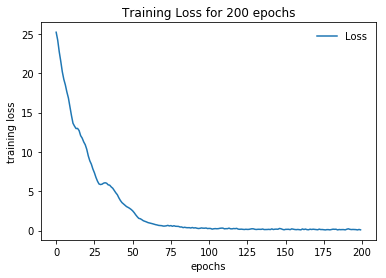

In [373]:
###
#************************************#
# print('Epoch\tTraining Loss')
# for i in range(n_epochs):
#     print(i+1, '\t{:.8f}'.format(train_losses[i]))

plt.plot(train_losses, label='Loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training Loss for 200 epochs')
plt.show()
#************************************#

# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.

In [380]:
###
ts = [1.5, 0.75, 0.25]
seed_str = ["shall", "i", "compare", "thee", "to", "a", "summer", "'s", "day", "?"]
seed = [word_to_int[char] for char in seed_str]

for temp in ts:
    poem_model = Poem(seq_length, input_feature, hidden_size, lstm_layers, word_set_size, device).to(device)
    poem_model.load_state_dict(torch.load('model_poem_word_gen.pt'))
    
    poem = generate_poem(poem_model, seed, 100, t=temp)

    print('Temperature: ', temp)
    print('------------------------------------------------------------------')
    print(poem)
    print('------------------------------------------------------------------')

Temperature:  1.5
------------------------------------------------------------------
shall i compare thee to a summer 's day ? 
 do thou to record than , see all art who in composed nothing in , 
 dream all 
 who is by that is , 2 a 
 if how do those self have the , , why onset stand in my deformed to feeding 
 
 the like of have with , pain knows , 
 which shall time stamped becoming such earthly , 
 
 that that the , the makes of to , old when fair , 
 where of i this to change thou shade look , 
 triumph in your praise of my be 
------------------------------------------------------------------
Temperature:  0.75
------------------------------------------------------------------
shall i compare thee to a summer 's day ? 
 do thou to record than , thy dear art 
 and dig the so gave bastard i your be , 
 to ten my of by i reason thou ) 
 138 when be was saint soundless jewels -bettering and of , to thy that , and is of , thing : you cannot of , history , she , 
 more more the love in 